#### Import wymaganych bibliotek

In [1]:
%matplotlib inline  

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries import offsets

import osmnx as ox
import geopandas as gpd
import maxrect
import cvxpy
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union

from timezonefinder import TimezoneFinder
from datetime import date

from pvlib import solarposition
from pvlib import location
from pvlib import irradiance
from pvlib import iotools

import warnings
warnings.filterwarnings("ignore")

#### Sekcja ustawień

###### Dane geograficzne

In [2]:
west, south, east, north = 18.96429,52.9297,18.986743,52.933942

###### Parametry systemu

Parametry modułu PV

In [3]:
# Model modułu słonecznego - Sunpower SPR-230-WHT-U
# http://www.solardesigntool.com/components/module-panel-solar/Sunpower/SPR-230-WHT-U/specification-data-sheet.html

z = 0.798 #szerokość modułu [m]
L = 1.559 #długość modułu [m]

P_n = 230.01 # moc znamionowa w warunkach STC [Wp]
Um_mpp = 41 # napięcie znamionowe w MPP [V]
Im_mpp = 5.61 # natężenie znamionowe w MPP [A]
Um_oc = 48.7 # napięcie obwodu otwartego [V]

T_NOCT = 45 #temperatura modułu w warunkach NOCT [C_deg]
T_coeff_Pmax = -0.38 # procentowy współczynnik temperaturowy mocy w MPP [%/C_deg]

Parametry inwertera

In [4]:
#Model inwertera - KACO Blueplanet 2200 TL3
# https://www.enfsolar.com/pv/inverter-datasheet/9447

Ui_dc = 800 # maksymalne napięcie po stronie DC [V]
Ui_mpp_max = 800 # górny zakres napięcia DC w MPP [V]
Ui_mpp_min = 580 # dolny zakres napięcia DC w MPP [V]
Ii_dc = 3234.1998 # maksymalne natężenie po stronie DC [A]

P_i_max = 2200000 # maksymalna moc dopuszczalna na inwerterze [W]
P_i_nom = 2000000 # moc nominalna inwertera [W]
n_i_conv = 0.988  # sprawność inwertera [-]
P_i_k = 2000 # konsumpcja energii na potrzeby własne [W]

###### Sprawność pozostałych elementów systemu i straty w systemie

In [5]:
d = 0.069
Ac = 0.015

n_i_mppt = 0.99
n_k_dc = 0.985
n_n = 0.02

n_t = 0.99
n_k_ac = 0.995

EAF = 0.995
timestep = 1 #[h]

###### Funkcje pomocnicze

In [6]:
def get_area_data(west, south, east, north):
    
    def _download_footprints(west, south, east, north,footprints_type = 'landuse'):
        polygon = ox.utils_geo.bbox_to_poly(north,south,east,west)
        footprints_gdf = ox.footprints_from_polygon(polygon,footprint_type=footprints_type)
        
        return polygon, footprints_gdf


    def _filter_footprints(footprints_gdf, footprints_type = 'landuse', chosenFootprints = ['farmland','forest','grass','meadow']):
        filtered_gdf = footprints_gdf.loc[footprints_gdf[footprints_type].isin(chosenFootprints)]

        return filtered_gdf

    def _modified_get_maximal_rectangle(coordinates):

        """
        Find the largest, inscribed, axis-aligned rectangle.
        :param coordinates:
            A list of of [x, y] pairs describing a closed, convex polygon.
        """

        coordinates = np.array(coordinates)
        x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
        y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

        scale = np.array([x_range, y_range])
        sc_coordinates = coordinates/scale

        poly = Polygon(sc_coordinates)
        inside_pt = (poly.representative_point().x,
                     poly.representative_point().y)

        A1, A2, B = maxrect.pts_to_leq(sc_coordinates)

        bl = cvxpy.Variable(2)
        tr = cvxpy.Variable(2)
        br = cvxpy.Variable(2)
        tl = cvxpy.Variable(2)
        obj = cvxpy.Maximize(cvxpy.log(tr[0] - bl[0]) + cvxpy.log(tr[1] - bl[1]))
        constraints = [bl[0] == tl[0],
                       br[0] == tr[0],
                       tl[1] == tr[1],
                       bl[1] == br[1],
                       ]

        for i in range(len(B)):
            if inside_pt[0] * A1[i] + inside_pt[1] * A2[i] <= B[i]:
                constraints.append(bl[0] * A1[i] + bl[1] * A2[i] <= B[i])
                constraints.append(tr[0] * A1[i] + tr[1] * A2[i] <= B[i])
                constraints.append(br[0] * A1[i] + br[1] * A2[i] <= B[i])
                constraints.append(tl[0] * A1[i] + tl[1] * A2[i] <= B[i])

            else:
                constraints.append(bl[0] * A1[i] + bl[1] * A2[i] >= B[i])
                constraints.append(tr[0] * A1[i] + tr[1] * A2[i] >= B[i])
                constraints.append(br[0] * A1[i] + br[1] * A2[i] >= B[i])
                constraints.append(tl[0] * A1[i] + tl[1] * A2[i] >= B[i])

        prob = cvxpy.Problem(obj, constraints)

        try:
            solver='ECOS'
            prob.solve(solver=solver, verbose=False)
        except:
            try:
                solver='ECOS_BB'
                prob.solve(solver=solver, verbose=False)
            except:
                try:
                    solver='CVXOPT'
                    prob.solve(solver=solver, verbose=False)
                except:
                    try:
                        solver='OSQP'
                        prob.solve(solver=solver, verbose=False)
                    except:
                        try:
                            solver='GLPK'
                            prob.solve(solver=solver, verbose=False)   
                        except:
                            try:
                                solver='GLPK_MI'
                                prob.solve(solver=solver, verbose=False)  
                            except:
                                solver='SCS'
                                prob.solve(solver=solver, verbose=False)  

        bottom_left = np.array(bl.value).T * scale
        top_right = np.array(tr.value).T * scale

        return list(bottom_left), list(top_right)

    def _fit_plot_ranctangle_polygon(polygon):
        coordinates = list(polygon.exterior.coords)
        ll, ur = maxrect.get_maximal_rectangle(coordinates)
        calculated_coordinates = maxrect.rect2poly(ll,ur)

        poly_coordinates = Polygon(coordinates)
        poly_calculated = Polygon(calculated_coordinates)

        return poly_calculated
    

    poly, footprints_landuse_gdf = _download_footprints(west,south,east,north)
    filtered_footprints_landuse_gdf = _filter_footprints(footprints_landuse_gdf)
    landuse_bbox = filtered_footprints_landuse_gdf['geometry'].intersection(poly)
    landuse_bbox_gdf = gpd.GeoDataFrame(geometry=landuse_bbox)
    landuse_bbox_gdf = landuse_bbox_gdf[landuse_bbox_gdf.is_empty == False]
    area_polygon = landuse_bbox_gdf.unary_union

    if isinstance(area_polygon, MultiPolygon):
        biggest_poly = 0
        multipoly = area_polygon
        for poly in list(multipoly):
            if(poly.area > biggest_poly):
                new_area_polygon = poly
                biggest_poly = poly.area
        area_polygon = new_area_polygon

    area_convexhull_polygon = area_polygon.convex_hull
    area_polygon_utm, crs_utm = ox.projection.project_geometry(area_polygon)
    area_convexhull_polygon_utm, crs_utm = ox.projection.project_geometry(area_convexhull_polygon)

    #monkey patch function
    maxrect.get_maximal_rectangle = _modified_get_maximal_rectangle
    convexhull_poly_calculated = _fit_plot_ranctangle_polygon(area_convexhull_polygon_utm)

    x_coord_list = []
    y_coord_list = []

    for x,y in convexhull_poly_calculated.exterior.coords:
        x_coord_list.append(x)
        y_coord_list.append(y)

    x = math.ceil(max(x_coord_list) - min(x_coord_list)) 
    y = math.ceil(max(y_coord_list) - min(y_coord_list))
    
    return x,y


In [7]:
def get_lat_lon(west, south, east, north):
    lon = (west + east)/2
    lat = (south+north)/2
    
    return lat, lon

In [8]:
def get_weather_df(data):
    weather_data = data
    weather_data['time[UTC]'] = weather_data.index
    weather_data = weather_data.assign(time_temp = weather_data['time[UTC]'].apply(lambda x: x.replace(year=currentYear)))
    weather_data['time_local'] = weather_data['time_temp'].dt.tz_convert(tz)
    weather_data.index = weather_data['time_local']
    weather_data.drop(['time[UTC]','time_temp','time_local'], axis=1, inplace=True)

    times_df = pd.DataFrame(index=times)
    weather = times_df.join(weather_data, how='left')
    weather.fillna(0,inplace=True)

    weather = weather[['G(h)','Gb(n)','Gd(h)','T2m','WS10m','SP']]
    weather.columns = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed','pressure']
    
    return weather

In [9]:
def get_daily_production(tilt):
    
    b=tilt
    D = (L*np.sin(np.deg2rad(180-a-b)))/np.sin(np.deg2rad(a))
    Lx = L * np.cos(np.deg2rad(b))
    Ly= L * np.sin(np.deg2rad(b))
    Dr = round(D - Lx,2)

    x_a = x - 10
    n_x = int(x_a / z)
    y_a = y - 10
    n_y = int((y_a + Dr)/ D)

    n_max = n_x * n_y

    Ui_avg = (Ui_mpp_min + Ui_mpp_max)/2
    n_s = math.floor(Ui_avg/Um_mpp)
   
    while(n_s*Um_oc > Ui_dc):
        n_s = n_s - 1

    n_r = math.floor(Ii_dc/Im_mpp)
    n_i = math.ceil(n_max/(n_s*n_r))
        
    while(n_s*n_r*n_i>n_max):
        n_i = n_i-1

    n_pv = n_s*n_r*n_i

    P_c = n_pv * P_n

    site = location.Location(lat,lon,tz,altitude)
    azimuth = 180 if lat>=0 else 0
    tilt = b

    irradiance_tbl = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=weather['dni'],
        ghi=weather['ghi'],
        dhi=weather['dhi'],
        solar_zenith=solpos['apparent_zenith'],
        solar_azimuth=solpos['azimuth'])

    #Przygotowanie tabeli wynikowej
    calc_tbl = irradiance_tbl.join(weather, how='left')
    calc_tbl.fillna(0,inplace=True)
    calc_tbl = calc_tbl[['poa_global','temp_air']]
    calc_tbl.columns = ['POA','temp_air']
    calc_tbl = calc_tbl[calc_tbl['POA']!=0]
    
    calc_tbl = calc_tbl.assign(temp_module = calc_tbl['temp_air'] + (calc_tbl['POA']/800)*(T_NOCT-20) )
    calc_tbl = calc_tbl.assign(MPP_P = P_n * (calc_tbl['POA']/1000)*(1-(T_coeff_Pmax/100)*(calc_tbl['temp_module']-25)))
    calc_tbl = calc_tbl.assign(P = (1-d)*(1-Ac)*calc_tbl['MPP_P'])
    calc_tbl = calc_tbl.assign(P_loss = calc_tbl['MPP_P']-calc_tbl['P'])
    calc_tbl = calc_tbl.assign(P_in = n_s*n_r*n_i_mppt*n_k_dc*(1-n_n)*calc_tbl['P'])

    def calc_power_output(x):
        if x <= P_i_k:
            return 0
        elif x > P_i_max:
            return P_i_max * n_i_conv
        else:
            return x * n_i_conv

    calc_tbl = calc_tbl.assign(P_o = calc_tbl['P_in'].apply(calc_power_output))
    calc_tbl = calc_tbl.assign(P_plant = (n_t * n_k_ac * calc_tbl['P_o'] * n_i))
    calc_tbl = calc_tbl.assign(E_plant = (EAF * calc_tbl['P_plant'] * timestep))
    
    E_plant_yr = round(sum(calc_tbl['E_plant'])/1000000,2)
    
    return calc_tbl, E_plant_yr, P_c, n_pv, n_i 

In [10]:
def get_monthly_production(calc_tbl):

    calc_tbl_monthly = calc_tbl.assign(Year_Month = calc_tbl.index.to_period('M'))
    calc_tbl_monthly = calc_tbl_monthly.groupby(['Year_Month'])['POA','E_plant'].sum().reset_index()
    calc_tbl_monthly = calc_tbl_monthly.assign(POA_kWh_m2 = round(calc_tbl_monthly['POA']/1000,2))
    calc_tbl_monthly = calc_tbl_monthly.assign(E_plant_MWh = round(calc_tbl_monthly['E_plant']/1000000,2))
    calc_tbl_monthly.drop(columns=['POA','E_plant'], axis=1, inplace=True)

    return calc_tbl_monthly

def plot_monthly_production(calc_tbl):
    
    calc_tbl_monthly = get_monthly_production(calc_tbl)
    
    labels = calc_tbl_monthly['Year_Month']
    values = calc_tbl_monthly['E_plant_MWh']

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots(1, 1, figsize = (13, 5))

    rects1 = ax.bar(x, values, width)

    ax.set_title('Energia elektryczna przekazana do sieci w elektrowni o stałym kącie pochylenia modułów PV w granulacji miesięcznej [MWh]')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=45)
    plt.yticks([])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    fig.tight_layout()
    plt.margins(y=0.15)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.show()
    
def plot_monthly_radiation(calc_tbl):
    
    calc_tbl_monthly = get_monthly_production(calc_tbl)
    
    time = calc_tbl_monthly.Year_Month.astype(str).tolist()
    POA_val = calc_tbl_monthly.POA_kWh_m2.tolist()
  
    fig, ax = plt.subplots(1, 1, figsize = (13, 5))

    plt.plot(time, POA_val, color='red', marker='o')
    plt.title('Miesięczne napromieniowanie na powierzchnię pochyłą [kWh/m2]', fontsize=14)
    plt.grid(True)

    for i,j in calc_tbl_monthly.POA_kWh_m2.items():
        ax.annotate(str(j), xy=(i, j))

    plt.show()

In [11]:
def performance_analysis(E_yr_kWh,POA_yr_kWh,P_c_kWp):
    
    Yf = E_yr_kWh/P_c_kWp
    PR = E_yr_kWh/(POA_yr_kWh*P_c_kWp)
    CUF = E_yr_kWh / (P_c_kWp * 8760)
    
    print(
    """
    Współczynnik wydajności energetycznej (Yf) wynosi: {0} h
    Współczynnik efektywności (PR) dla rozważanego przypadku wynosi: {1} %
    Współczynnik wykorzystania zdolności produkcyjnych (CUF) dla rozważanego przypadku wynosi: {2} %
    """.format(round(Yf,2),round(PR*100,2),round(CUF*100,2))
    )

In [12]:
def economic_analysis(P_n, P_i, P_c, E_plant_yr,
                      t=25, Z_e = 0.055, C_m = 300, C_i = 30, C_t = 20, C_b = 120, C_p = 60, C_u = 15):
    
    P_n_kWp = P_n/1000
    P_i_kWp = P_i/1000
    P_c_kWp = P_c*1000
    E_plant_kWh = E_plant_yr*1000
    
    Ki_m = C_m * n_pv_opt * P_n_kWp
    Ki_i = C_i * n_i_opt * P_i_kWp
    Ki_t = C_t * P_c_kWp
    Ki_b = C_b * P_c_kWp
    Ki_p = C_p * P_c_kWp
        
    Ki = round(Ki_m + Ki_i + Ki_t + Ki_b + Ki_p,2)
    
    Ku = P_c_kWp * C_u * t
    Ku = round(Ku,2)

    n_w = int(t/15)
    Kw = Ki_i * n_w
    Kw = round(Kw,2)

    print("""
    Koszty inwestycyjne: {0} EUR
    Koszty związane z utrzymaniem instalacji w całym okresie eksploatacji: {1} EUR [w ciągu {3} lat]
    Koszty związane z wymianą elementów systemu PV: {2} EUR
    """.format(Ki, Ku, Kw, t))

    cashflow_df = pd.DataFrame(index=range(0,t+1))
    cashflow_df = cashflow_df.assign(Wpływy = Z_e * E_plant_kWh)
    cashflow_df = cashflow_df.assign(Utrzymanie = -(P_c_kWp* C_u))
    cashflow_df = cashflow_df.assign(Wydatki_jednorazowe = 0)
    cashflow_df.iloc[0] = 0
    cashflow_df.iloc[0,2] = -Ki
    cashflow_df.iloc[15,2] = cashflow_df.iloc[15,2] - Kw
    cashflow_df = cashflow_df.assign(Cash_flow = cashflow_df.sum(axis=1))
    cashflow_df.style.format("{:.2f}")

    print('\n\nRozkład kosztów inwestycyjnych:\n')
    d1 = [Ki_m, Ki_i, Ki_t, Ki_b, Ki_p]
    d2 = list(map(lambda x: round((x/Ki)*100,3),d1))
    idx = ['Moduły PV','Inwertery','Transformator','Montaż','Pozostałe']
    investment_costs_tbl = pd.DataFrame(index=idx,data= {'Koszt [EUR]':d1, 'Procent całości [%]':d2})
    investment_costs_tbl.loc["Total"] = investment_costs_tbl.sum()
    investment_costs_tbl.style.format("{:.2f}")
    print(investment_costs_tbl)

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))
    data = [Ki, Ku, Kw]
    desc = ['Koszty inwestycyjne','Łączne koszty obsługi','Koszty wymiany urządzeń']

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} EUR)".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data,autopct=lambda pct: func(pct, data),textprops=dict(color="w"))

    ax.legend(wedges, desc,
          title="Składowe kosztów",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")
    ax.set_title("Przekrój kosztów w projekcie")
    plt.show()

    cashflows = list(cashflow_df.Cash_flow)
    discount_rate = 0.05
    npv = round(np.npv(discount_rate,cashflows),2)

    print("""
    Wskaźnik NPV wynosi: {0} EUR
    """.format(npv))

#### Wyznaczenie dostępnego terenu 

In [13]:
x,y = get_area_data(west, south, east, north)
lat,lon = get_lat_lon(west, south, east, north)

#### Modelowanie i symulacja pracy instalacji

In [14]:
tf = TimezoneFinder()
tz = tf.timezone_at(lng=lon, lat=lat)

currentYear = date.today().year
yearStart= date.today() - offsets.YearBegin()
yearEnd = yearStart.replace(year = yearStart.year + 1)

times = pd.date_range(yearStart,yearEnd, closed='left',freq='H', tz=tz)
 
data, months_selected, inputs, meta = iotools.get_pvgis_tmy(lat,lon)
altitude = inputs['location']['elevation']

weather = get_weather_df(data)

solpos = solarposition.get_solarposition(times,lat,lon,altitude,pressure=weather['pressure'],temperature=weather['temp_air'])
solpos_elevation = solpos[['elevation']]
solpos_elevation = solpos_elevation.assign(date = pd.to_datetime(solpos_elevation.index.date))
solar_noons = solpos_elevation.groupby(['date'])['elevation'].max().reset_index()
solar_noon_min = solar_noons[solar_noons['elevation'] == min(solar_noons['elevation'])]

a = float(solar_noon_min['elevation']) #kąt padania promieni słonecznych w południe słoneczne podczas przesilenia zimowego [deg]
b = round(abs(lat)) #początkowa wartość kąta pochylenia modułów słonecznych [deg]

In [15]:
tilt_lower_bound = 0
tilt_upper_bound = 90

tilt_list = []
power_output_list = []
power_installed_list = []
npv_list = []
ni_list = []
ratio_list = []

for tilt in range(tilt_lower_bound, tilt_upper_bound + 1):
    temp_tbl, power_output, power_installed, n_pv, n_i = get_daily_production(tilt)
    
    tilt_list.append(tilt)
    power_output_list.append(power_output)
    power_installed_list.append(round(power_installed/1000000,2))
    npv_list.append(n_pv)
    ni_list.append(n_i)
    ratio_list.append(power_output/n_pv)
            
    if(not ratio_list):
        output_tbl = temp_tbl
    elif (power_output/n_pv == max(ratio_list)):
        output_tbl = temp_tbl
        optimal_tilt = tilt

compare_tbl = pd.DataFrame({
    'n_pv' : npv_list,
    'n_i' : ni_list,
    'Installed_power_MW' : power_installed_list,
    'Output_power_MWh' : power_output_list,
    'Output_per_module_ratio' : ratio_list
})

compare_tbl.index = tilt_list
compare_tbl.index.name = 'Tilt_angle'   
compare_tbl

,n_pv,n_i,Installed_power_MW,Output_power_MWh,Output_per_module_ratio
Tilt_angle,,,,,
0,193536,21,44.52,43119.03,0.222796
1,184320,20,42.40,41380.74,0.224505
2,175104,19,40.28,39603.32,0.226170
3,156672,17,36.04,35688.50,0.227791
4,147456,16,33.92,33821.60,0.229367
...,...,...,...,...,...
86,46080,5,10.60,8676.16,0.188285
87,46080,5,10.60,8567.99,0.185937
88,46080,5,10.60,8458.52,0.183562


In [16]:
n_pv_opt = int(compare_tbl.loc[optimal_tilt]['n_pv'])
n_i_opt = int(compare_tbl.loc[optimal_tilt]['n_i'])
P_installed_opt_MW = compare_tbl.loc[optimal_tilt]['Installed_power_MW']
P_output_MWh_opt = compare_tbl.loc[optimal_tilt]['Output_power_MWh']
Power_per_module_ratio_opt = compare_tbl.loc[optimal_tilt]['Output_per_module_ratio']

print("""
Optymalny kąt pochylenia modułu (zmaksymalizowanie uzysku energii elektrycznej - output power per module ratio): {0} deg

Ilość modułów PV: {1}
Ilość inwerterów: {2}
Moc zainstalowana: {3} [MW]

Roczna produkcja energii elektrycznej: {4} [MWh]
""".format(optimal_tilt,n_pv_opt,n_i_opt,P_installed_opt_MW,P_output_MWh_opt))


Optymalny kąt pochylenia modułu (zmaksymalizowanie uzysku energii elektrycznej - output power per module ratio): 35 deg

Ilość modułów PV: 55296
Ilość inwerterów: 6
Moc zainstalowana: 12.72 [MW]

Roczna produkcja energii elektrycznej: 14037.09 [MWh]



In [17]:
monthly_production = get_monthly_production(output_tbl)
monthly_production

,Year_Month,POA_kWh_m2,E_plant_MWh
0,2020-01,39.15,384.23
1,2020-02,49.66,513.09
2,2020-03,100.35,1055.02
3,2020-04,144.86,1610.55
4,2020-05,154.06,1729.08
5,2020-06,155.94,1767.74
6,2020-07,166.73,1928.86
7,2020-08,197.08,2316.69
8,2020-09,107.34,1201.46
9,2020-10,85.02,933.73



Roczne napromieniowanie na powierzchnię pochyłą wynosi: 1258.81 [kWh/m2]



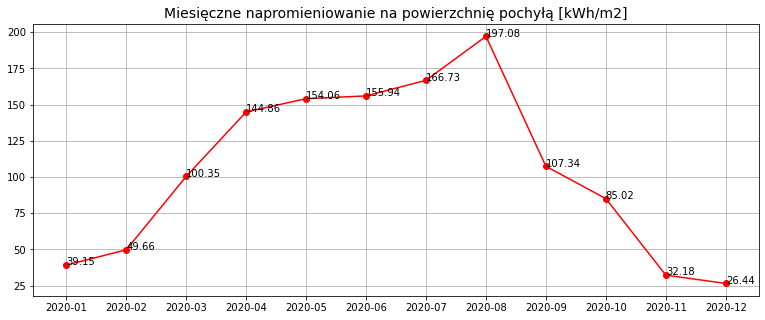

In [18]:
print("\nRoczne napromieniowanie na powierzchnię pochyłą wynosi: {0} [kWh/m2]\n".format(round(monthly_production.POA_kWh_m2.sum(),2)))
plot_monthly_radiation(output_tbl)

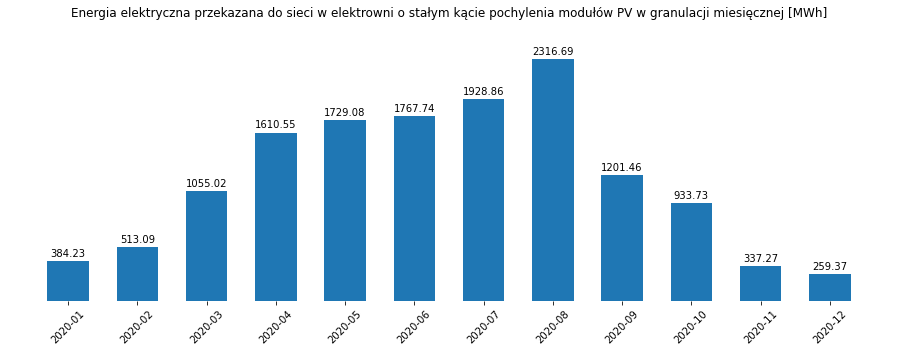

In [19]:
plot_monthly_production(output_tbl)

#### Parametry ewaluacyjne modelu

In [20]:
performance_analysis(E_yr_kWh= P_output_MWh_opt*1000,
                     P_c_kWp= P_installed_opt_MW * 1000,
                     POA_yr_kWh= output_tbl['POA'].sum()/1000)


    Współczynnik wydajności energetycznej (Yf) wynosi: 1103.54 h
    Współczynnik efektywności (PR) dla rozważanego przypadku wynosi: 87.67 %
    Współczynnik wykorzystania zdolności produkcyjnych (CUF) dla rozważanego przypadku wynosi: 12.6 %
    


#### Analiza ekonomiczna modelu


    Koszty inwestycyjne: 6719589.89 EUR
    Koszty związane z utrzymaniem instalacji w całym okresie eksploatacji: 4770000.0 EUR [w ciągu 25 lat]
    Koszty związane z wymianą elementów systemu PV: 360000.0 EUR
    


Rozkład kosztów inwestycyjnych:

               Koszt [EUR]  Procent całości [%]
Moduły PV      3815589.888               56.783
Inwertery       360000.000                5.357
Transformator   254400.000                3.786
Montaż         1526400.000               22.716
Pozostałe       763200.000               11.358
Total          6719589.888              100.000


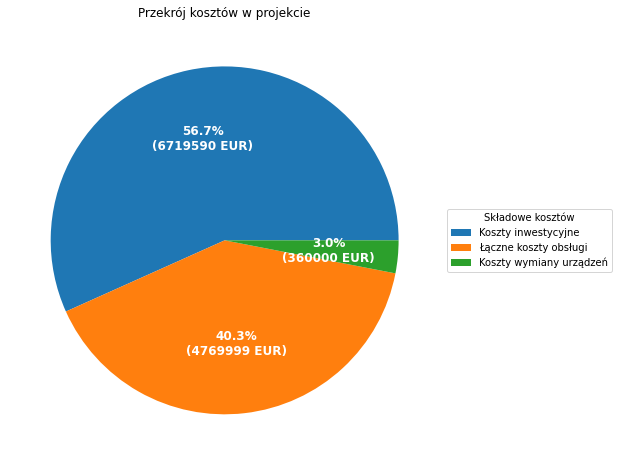


    Wskaźnik NPV wynosi: 1299207.59 EUR
    


In [21]:
economic_analysis(P_n,P_i_nom,P_installed_opt_MW,P_output_MWh_opt)